<h1>Image & Video Colorizer</h1>
<h3>Jason Lombino - Capstone Project Submission</h3><hr>

In [1]:
import os
import random
import colorizerutils as utils
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import losses
from keras.models import load_model

<h1>Business Introduction</h1>

<img src=resources/bentocolor_logo.png> 

<p>
BentoColor is widely known for providing colorization services for both personal and industrial scale customers.
</p>

<p>
While BentoColor employs many talented technicians to provide colorization services, the recent advances in machine learning has led them to question whether it can be an effective tool for colorizing images and videos. A successful implementation of machine learning based colorization tools can assist technicians greatly with their colorization work. BentoColor aims to bolster their efforts in the field of colorization by leveraging their technicians' increased productivity. This will help attract large customers such as broadcasting companies and museums as well as individuals with small-scale colorization jobs.
</p>

<h1>Colorization Background</h1>

<h3>Current State of Colorization</h3>

<p>
Colorization is the process of converting a black and white image or video into one with color. There are many techniques available for use in colorization. For example, manual colorization is a laborious process where technicians color each image or frame individually using image editing software. While it is somewhat common for still images, advancements in image processing algorithms have resulted in manual colorization becoming mostly obsolete for videos. 
</p>

<p>
These algorithms allow for objects to be tracked between video frames. If one frame is colorized manually, it is often possible for many similar frames to be colorized automatically. It is even feasible to automatically account for changes in brightness and perspective. This process, while substantially easier than manually colorizing a video, is still very time consuming for technicians. They need to verify that the algorithms are tracking objects and applying colors correctly for each frame individually. In addition, technicians need to manually add colors whenever a new object enters the frame or the scene changes substantially.
</p>

<p>
BentoColor aims to address these inefficiencies by colorizing images and parts of videos automatically using machine learning. When combined with current technologies, the result will be a significantly faster, more efficient colorization process.
</p>

<h3>BentoColor Technology</h3>

<p>
Using machine learning to colorize images comes with a unique set of challenges. For instance, what color is a shoe? While this may seem like a simple question to a human, it is deceptively tricky for a computer to answer as there really is no typical shoe. While a boot is most commonly brown, no one would think twice if they saw a boot that was black or beige. Any computer would struggle to learn from such contradictory information though. This situation is extremely common, but with enough training data it should be possible for a model to learn to generalize and output sensible colors.
</p>

<p>
Despite the many challenges, BentoColor plans to utilize neural networks to automatically colorize images and video frames. Specifically, BentoColor plans to utilize a U-Net similar to the one described in [<a href=https://arxiv.org/pdf/1505.04597.pdf>U-Net: Convolutional Networks for Biomedical Image Segmentation</a>] and [<a href=https://www.tensorflow.org/tutorials/generative/pix2pix>pix2pix: Image-to-image translation with a conditional GAN</a>] to accomplish this goal. The U-Net architecture begins with a downsampling section which extracts the features from a given input image. This is followed by an upsampling section which determines what color should be applied to which feature. Skip connections are present between the individual downsampling and upsampling layers to allow the network to pass forward information about major patterns in the input image.
</p>

<h1>Image Preparation</h1>

<h3>Working with Images</h3>

<p>
Before training any machine learning models, the image and video frame data must be prepared using the opencv (cv2) package. While ideally each image or frame from a video could be colorized at its original resolution, the limited hardware available to BentoColor necessitates each frame being downscaled to 64x64 pixels. In order to augment the training datasets, each image was flipped vertically or horizontally at random. In addition, a random rotation of 0, 90, 180, or 270 degrees was applied to each image. These transformations were performed to augment the limited dataset and prevent overfitting.
</p>

<p>
The LAB color space is much more convenient than the typical RGB representation for the task of colorization. This is because in the LAB color space, the entire grayscale part of the image is contained in just the L channel. Making gray using RGB would require mixing all three colors in an equal proportion. This is convenient because the model will only need to predict new values for the A and B color channels. The original L channel can just be combined with the predicted A and B to make a fully colored LAB image. In contrast, if RGB were used, the model would need to predict new values for all three color channels. This reduces the complexity of the model substantially.
</p>

<h3>Image Dataset - Landscapes</h3>

<p>
The first dataset used to train a model is [<a href=https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images>Landscape Recognition | Image Dataset | 12k Images</a>] found on Kaggle. The dataset contains 10,000 training images, 1,500 validation images, and 500 test images of landsacpes. These landscapes fall into five categories: Coast, Desert, Forest, Glacier, and Mountain. All five categories were combined to form one large cohesive dataset while training these models. While the original images were of varying resolutions, every image was resized to 64x64 pixels and randomly flipped and rotated as mentioned previously.
</p>

<h3>Example Training Images</h3>

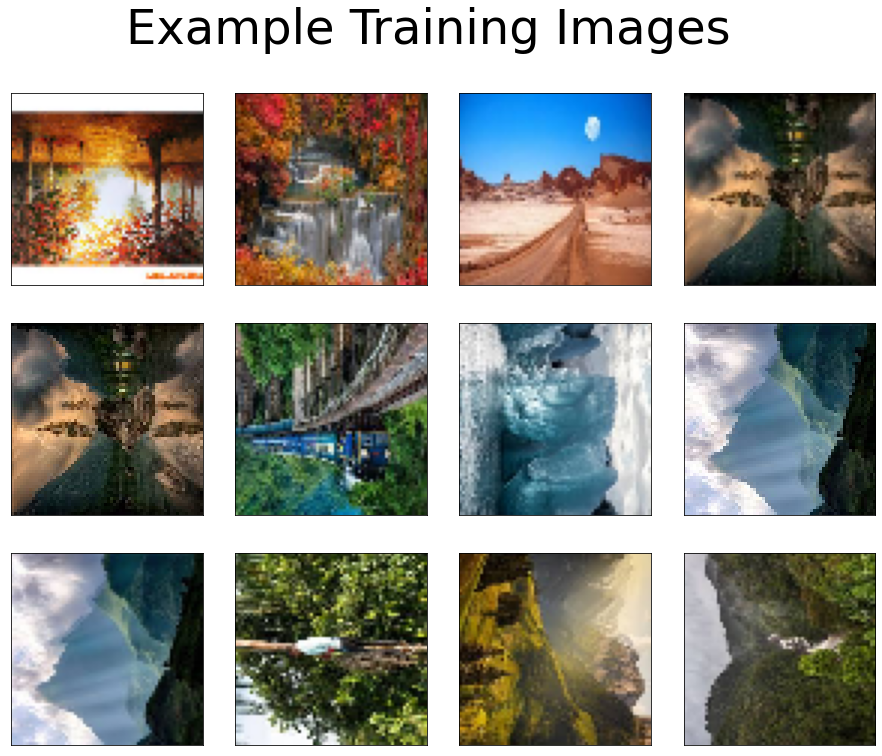

In [2]:
example_paths = random.sample(os.listdir('../images/train_images/'),12)
example_paths = ['../images/train_images/' + filename for filename in example_paths]
example_images = [utils.load_and_resize(path,transform=True) for path in example_paths]

fig, ax = plt.subplots(3,4,figsize=(16,12))
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.imshow(example_images[j+3*i])
        col.set_xticks([])
        col.set_yticks([])
fig.set_facecolor('#FFFFFF')
fig.subplots_adjust(wspace=0.02, hspace=0.2)
fig.suptitle('Example Training Images',fontsize=48);

<h1>Modeling Preparation</h1>

<h3>Neural Network Common Layers</h3>

<p>
The U-Net generator responsible for colorizing images has two main sections: a downsampling section, and an upsampling section. Each of these sections consists of repeated convolutional/deconvolutional layers, activation functions, and normalization layers. In order to streamline the implementation, these layers were grouped together into downsampling and upsampling blocks. The upsampling blocks are more complicated because they also include a skip connection to a layer from a downsampling block. The downsampling blocks will also prove useful in the discriminator once generative adversarial networks are added to the mix.
</p>

<p>
The code used to build these blocks of layers is shown below.
</p>

In [3]:
#  Downsampling block for use in generator and discriminator
def downsampling(filters,stride,prev_layer):

    init = initializers.RandomNormal()

    block = layers.Conv2D(filters,strides=stride,kernel_size=4,padding='same',kernel_initializer=init,use_bias=False)(prev_layer)
    block = layers.BatchNormalization()(block)
    block = layers.LeakyReLU(0.2)(block)

    return block

# Upsampling block for use in generator only
# Skip layer should be the same shape as the output to the transpose convolutional layer
# Or twice the size of the prev_layer input
def upsampling(filters,stride,prev_layer,skip_layer):

    init = initializers.RandomNormal()

    block = layers.Conv2DTranspose(
        filters,strides=stride,kernel_size=4,padding='same',kernel_initializer=init,use_bias=False)(prev_layer)
    block = layers.BatchNormalization()(block)
    block = layers.Concatenate()([block,skip_layer])
    block = layers.LeakyReLU(0.2)(block)
    block = layers.Dropout(0.3)(block)

    return block

<h3>Generator U-Net Architecure</h3>

<p>
The (not to scale) diagram below shows the literature-based U-Net architecture for the generator that is used to colorize the images. It accepts one grayscale (L channel from LAB) image as an input and predicts two color channels (A and B channels from LAB) for that grayscale image. The predicted channels can be recombined with the input grayscale image to form a fully colored image. The input and output image sizes are both 64x64 pixels.
</p>

<p>
The generator is built using a series of downsampling blocks followed by a series of upsampling blocks. A stride of 2 was used for each convolutional layer in the downsampling blocks so the image resolution is halved after each. Similarly, a stride of 2 was used for each deconvolutional layer in the upsampling blocks so the image resolution is doubled after each. The number of filters used increases with each consecutive downsampling block up to a maximum of 256 in order to capture the increasing number of combinations of patterns in the images. Inversely, the number of filters decreases with each consecutive upsampling block to a minimum of 32 to deconstruct these combinations of patterns back into simpler ones.
</p>

<p>
The code used to make the generator is shown below.
</p>

<img src=resources/generator_arch.png>

In [4]:
def make_generator():

    init = initializers.RandomNormal()

    # Model input is a (64x64) grayscale image
    model_input = layers.Input(shape=(64,64,1))

    # Downsampling stack
    down0 = downsampling(filters=32,stride=1,prev_layer=model_input) # (64x64) -> (64x64)
    down1 = downsampling(64,2,down0) # (64x64) -> (32x32)
    down2 = downsampling(128,2,down1) # (32x32) -> (16x16)
    down3 = downsampling(256,2,down2) # (16x16) -> (8x8)
    down4 = downsampling(256,2,down3) # (8x8) -> (4x4)
    down5 = downsampling(256,2,down4) # (4x4) -> (2x2)
    down6 = downsampling(256,2,down5) # (2x2) -> (1x1)


    # Upsampling stack
    up5 = upsampling(filters=256,stride=2,prev_layer=down6,skip_layer=down5) # (1x1) -> (2x2)
    up4 = upsampling(256,2,up5,down4) # (2x2) -> (4x4)
    up3 = upsampling(256,2,up4,down3) # (4x4) -> (8x8)
    up2 = upsampling(128,2,up3,down2) # (8x8) -> (16x16)
    up1 = upsampling(64,2,up2,down1) # (16x16) -> (32x32)
    up0 = upsampling(32,2,up1,down0) # (32x32) -> (64x64)
    
    # Model output is (64x64) with 2 color channels with values between -1 and 1
    model_output = layers.Conv2DTranspose(
        2,strides=1,kernel_size=4,padding='same',activation='tanh',kernel_initializer=init,use_bias=False)(up0)

    model = keras.models.Model(model_input,model_output)
    return model

<h3>Discriminator CNN Architecure</h3>

<p>
The (not to scale) diagram below shows the standard convolutional neural network discriminator. The discriminator is used to train the generator adversarially. It accepts three image color channels: one grayscale and two color. The output is a matrix that shows whether the discriminator thinks each section of the image was created by the generator (represented as 0) or an original image (represented as 1). The discriminator uses a standard convolutional neural network architecture. It is built using repeated downsampling blocks with an increasing number of filters designed to capture the increasing number of conbinations of patterns in the images.
</p>

<p>
The code used to make the discriminator is shown below.
</p>

<img src=resources/discriminator_arch.png></img>

In [5]:
def make_discriminator():

    init = initializers.RandomNormal()

    gray_input = layers.Input(shape=(64,64,1))
    color_input = layers.Input(shape=(64,64,2))

    # Gray and colored inputs are combined
    concat_input = layers.concatenate([gray_input,color_input])

    # Downsampling stack
    down0 = downsampling(filters=64,stride=2,prev_layer=concat_input) # (64x64) -> (32x32)
    down1 = downsampling(128,2,down0)        # (32x32) -> (16x16)
    down2 = downsampling(256,2,down1)        # (16x16) -> (8x8)

    # Model output is (8x8) with unbounded values (no activation)
    model_output = layers.Conv2D(1,2,strides=1,padding='same',kernel_initializer=init,use_bias=False)(down2)

    model = keras.Model(inputs=[gray_input,color_input],outputs=model_output)
    return model

<h1>Training with Mean Squared Error Loss</h1>

<h3>MSE Background</h3>

<p>
The first attempt at training the generator to colorize images used mean squared error loss. To calculate this loss, subtract the color values for a pixel in the generated image from the color values for the same pixel in the original color image and square the result. Repeat this for each pixel in the image and add all the squared values. Then divide that by the number of pixels in the image. This method results in loss getting smaller as the generates image's colors get closer to the original image's colors. Because the error is squared, pixels that are very far from their intended values are penalized more heavliy than pixels that are close to their intended values.
</p>

<img src=resources/mse_graphic.png width=300></img>

<p>
The function used to calculate the mean squared error loss is shown below. More information on the model trained using mean squared error as well as the code used to train this model can be found in <a href=./MSE_Colorizer.ipynb>this notebook.
</p>

In [6]:
def generator_loss(generator_output,color_channels):

    # Loss is the mean squared difference between the generated images
    # and the original colored images
    mse = losses.MeanSquaredError()
    mse_loss = mse(generator_output,color_channels) 

    return mse_loss

<h3>Training Results</h3>

<p>
The chart below shows the model's mean squared error loss plotted against the number of steps the model was trained for. The clear downward trend signals that the model's output images are becoming closer to the original color images over time. The training was ended because the model's improvements in loss were slowing down and training the model more in this situation could easily lead to overfitting. Results for images colorized using this model can be found in the Image Colorization Results section below.
</p>

<img src=resources/MSE_Loss_TBoard.jpg width=600></img>

<h1>Generative Adversarial Networks</h1>

<h3>GAN Background</h3>

<p>
Following training using mean squared error loss, a separate model was trained using a combination of mean squared error and adversarial loss. A generative adversarial network architecutre based on [<a href=https://arxiv.org/pdf/1611.07004.pdf>Image-to-Image Translation with Conditional Adversarial Networks</a>] was used with a modified and simplified loss function for this purpose. 
</p>

<p>
Generative adversarial networks (GANs) actually consist of two separate neural networks: the generator and the discriminator. The generator is primarily responsible for colorizing the images while the discriminator is responsible for finding differences between the generated colors and the original image's colors. If the discriminator is able to find differences, the generator is trained to produce images without those differences. The discriminator is then tasked with finding even more differences for the generator to fix. This is the general training loop for a GAN and can be repeated until there are no differences for the discriminator to find between the generated images and the original images. This training loop is pictured in the diagram below.
</p>

<img src=resources/Gan_Arch.png width=300></img>

<p>
In this case, the generator is the U-Net described in the Generator U-Net Architecture section, and the discriminator is the CNN described in the Discriminator CNN Architecture section.
</p>

<h3>Advantages of GANs</h3>

<p>
The main advantage of GANs is that they are very good at generating data that is similar to existing data. The generator, capable of fooling a well-trained discriminator, may very well be capable of fooling the average person into thinking they are looking at an original color image. GANs are also good at producing convincing results when the training dataset is smaller than desired. This is because they are excellent at picking up on and reporoducing most of the patterns present in the training dataset. For this reason, generating extra data using a GAN to suppliment a small dataset has been explored in the past with varying success.
</p>

<h3>Disadvantages of GANs</h3>

<p>
One disadvantage of GANs is that they have a variety of potential failure modes. For example, if either the generator or the disriminator is too strong relative to its counterpart, the weaker network will not learn well at all. In addition, because GANs are composed of two neural networks, they are more computationally and time intensive to train than a typical neural network. It is vital to select a network architecture and dataset that will allow for convergence within a reasonable amount of time on the available hardware.
</p>

<h1>Training with Adversarial Loss</h1>

<h3>Generator Training</h3>

<p>
The generator recieves a grayscale image as an input and predicts color channels based on that image. A partial loss is then calculated based on mean squared error as described above. In addition to this, the generated images are also sent to the discriminator. The generator wants to fool the discriminator, so the loss is calculated based on how many sections of the image the discriminator thinks are generated images. The loss is high if the discriminator thinks there are many generated sections, and low if the discriminator thinks there are many original colored sections. These discriminator predictions as well as the scaled mean squared error loss are then used to update the weights of the generator. The diagram below shows the generator training loop in detail.
</p>

<img src=resources/Gen_Training_Loop.png width=300></img>

<p>
The function used to calculate the generator loss is shown below. More information on the generator trained using adversarial and MSE loss as well as the code used to train it can be found in <a href=./GAN_Colorizer.ipynb>this notebook</a>.
</p>

In [7]:
def generator_loss(disc_output_generated,generator_output,color_channels):

    # Part of the loss is based on the discriminator output on fake images
    cross_entropy = losses.BinaryCrossentropy(from_logits=True,label_smoothing=0.1)

    # Part of the loss (scaled) is based on the difference between the
    # generated images and the original colored images
    mse = losses.MeanSquaredError()
    mse_scaler =100

    # Generator wants the discriminator to classify the generated images as 1 (real)
    # Adersarial loss is the defference between all 1s and the actual discriminator output
    adversarial_loss = cross_entropy(tf.ones_like(disc_output_generated),disc_output_generated)
    mse_loss = mse(generator_output,color_channels) 

    # Return all three losses for tensorboard
    return adversarial_loss + (mse_scaler * mse_loss), adversarial_loss, mse_loss

<h3>Discriminator Training</h3>

<p>
The discriminator recieves either original color images or images colored by the generator as an input. The goal of the discriminator is to classify sections of images colored by the generator as fake (0) and classify sections of original colored images as real(1). The discriminator looks at sections of images rather than images as a whole to provide the generator with more granular feedback. Discriminator loss is low if it correctly identifies the original and generated colors, and high if it incorrectly identifies them. These predictions are then used to update the weights of the discriminator. The training loop is pictured in the diagram below.
</p>

<img src=resources/Disc_Training_Loop.png width=300></img>

<p>
The function used to calculate the discriminator loss is shown below. More information on the discriminator as well as the code used to train it can be found in <a href=./GAN_Colorizer.ipynb>this notebook</a>.
</p>

In [8]:
def discriminator_loss(disc_output_generated,disc_output_real):

    cross_entropy = losses.BinaryCrossentropy(from_logits=True,label_smoothing=0.1)

    # Discriminator wants to classify real images as 1 and generated
    # images as 0. Loss is the difference between the desired outputs
    # and the actual outputs
    real_loss = cross_entropy(tf.ones_like(disc_output_real),disc_output_real)
    generated_loss = cross_entropy(tf.zeros_like(disc_output_generated),disc_output_generated)

    total_loss = real_loss + generated_loss
    return total_loss

<h3>Training Results</h3>

<p>
The four graphs below show the discriminator loss, generator loss (adversarial), generator loss (mean squared error), and total generator loss.
</p>

<ul>
<li>The discriminator loss starts high and decreases over time as the discriminator learns to distinguish between the generator's predicted colors and the original colored images.</li>
<li>The generator adversarial loss is the inverse of the discriminator loss. It increases over time because the discriminator improves more quickly than the generator.</li>
<li>The generator MSE loss decreases over time as the generator predicted images more closely resemble the original color images. This improvement slows over time and eventually reverses as the adversarial loss begins to dominate.</li>
<li>The generator total loss is the weighted sum of the adversarial and MSE loss components. The MSE component is larger initially, but the adversarial component eventually begins to dominate.</li>
</ul>

<img src=resources/GAN_Loss_TBoard.jpg></img>

<h1>Image Colorization Results</h1>

<p>
Here, results are shown for both models. The leftmost image is the grayscale image. The second image is the output from the generator trained using only MSE loss. The third image is the output from the generator trained using adversarial and MSE loss combined. The rightmost image is the original color image.
</p>

<h3>Colorized Images</h3>

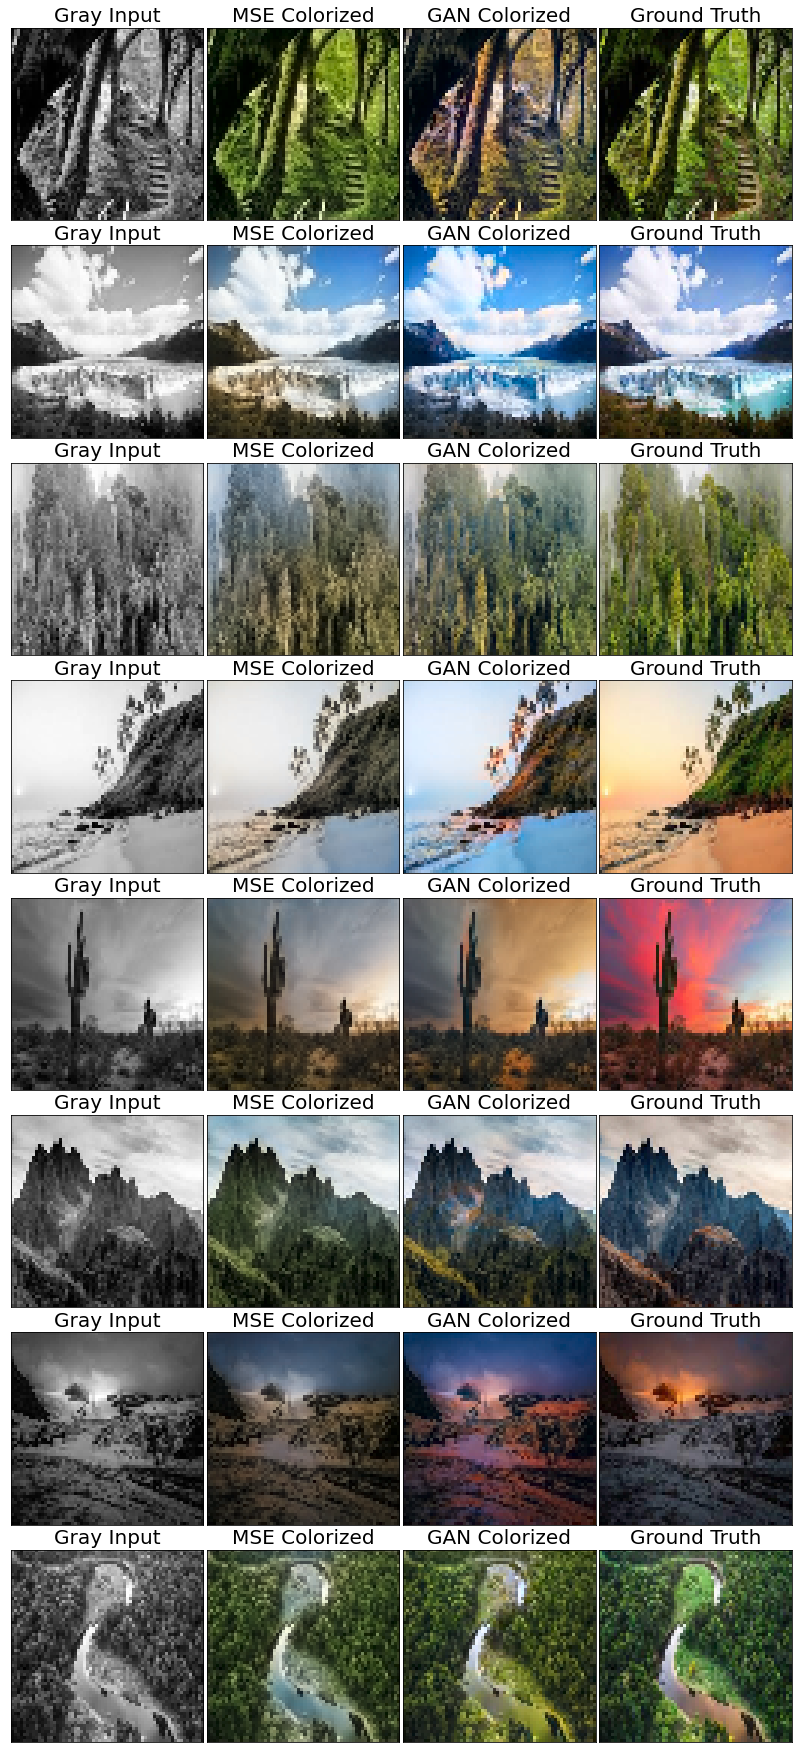

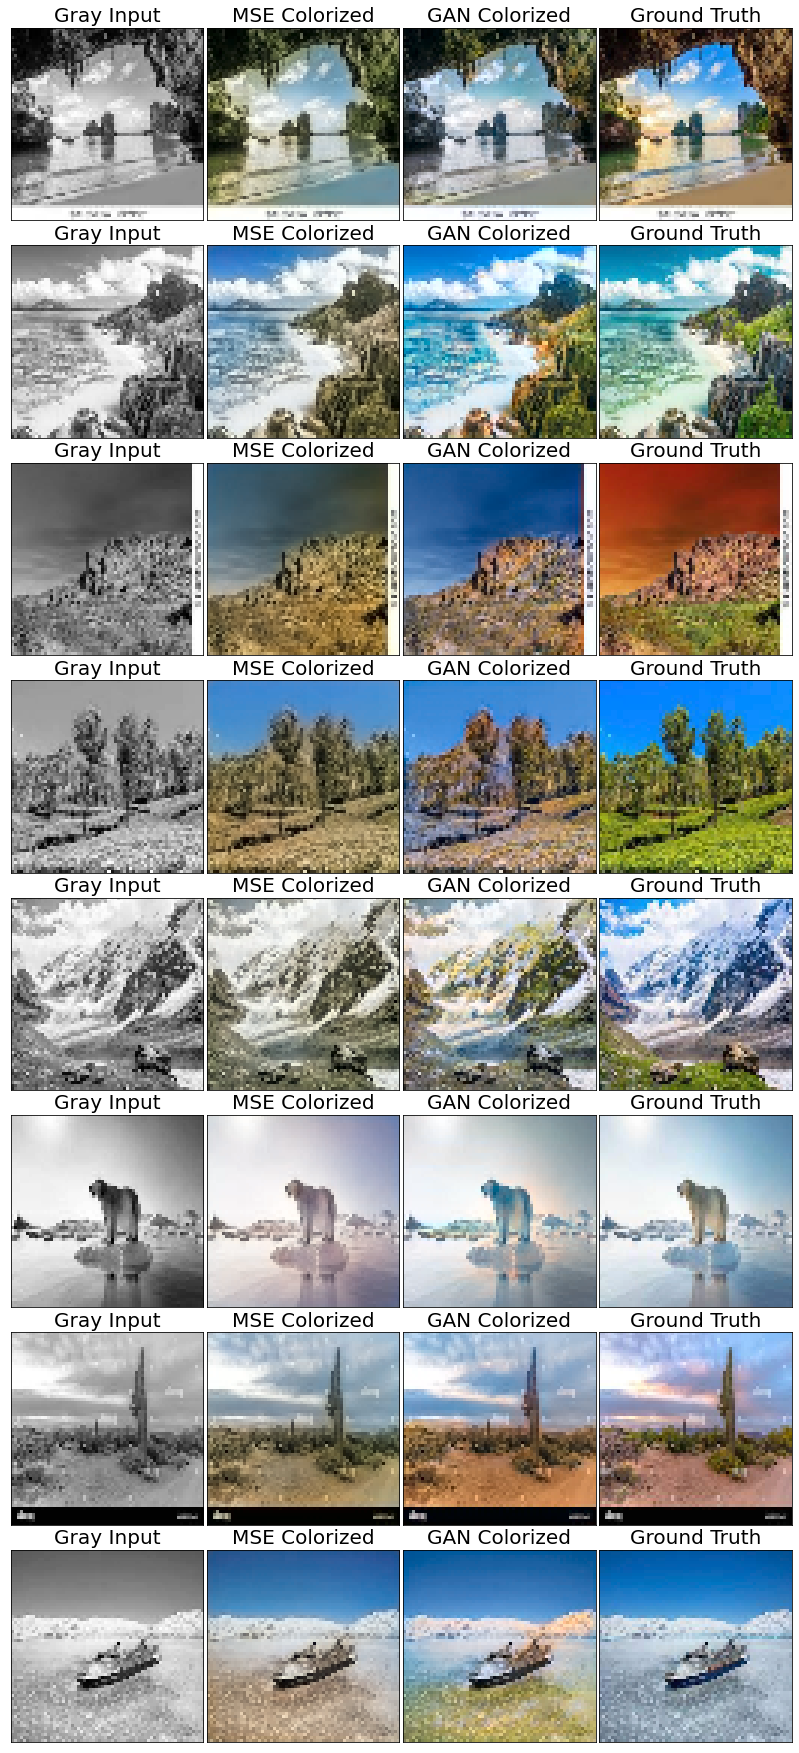

In [9]:
mse_gen = load_model('models/1-5-23/mse/generator.h5')
gan_gen = load_model('models/1-5-23/gan/generator.h5')

for test_batch in range(2):
    test_images = utils.image_loader(directory='../images/test_images/',
     batch_size=8,training=False).__getitem__(test_batch)
    utils.display_images(gray_channel=test_images[0],color_channels=test_images[1],
    generator1=mse_gen,gen1_title='MSE Colorized',generator2=gan_gen,gen2_title='GAN Colorized');

<h3>Interpretation</h3>

<p>
<b>The interpretation of these results and the relative success of each model is highly subjective. Each person viewing the results may prefer a different colorization.</b>
</p>

<p>
There are several important questions to ask when determining how well a given model colorizes images. These include:

<ul>
<li>How well do the generator colorized images match the original training and test images?</li>
<li>Are the differences between the original and generator colorized images expected or reasonable?</li>
<li>Are there any major defects or inconsistencies in the generator colorized images?</li>
<li>Are the generator colorized images vibrant and colorful when appropriate?</li>
<li>Do the predicted colors accentuate details in the images?</li>
</ul>

<p>
In this case, there are not many defects in the generator colorized images. The GAN produces more vibrant and detailed images while the generator trained using only MSE tends to use fewer colors overall. The GAN is also noticably better at capturing and accentuating the details in the images while the generator trained using MSE tends to apply colors across object boundaries more often. The GAN deviates more from the colors in the original image, but it often uses colors that could also be appropriate for the objects in the scene.
</p>

<h1>Video Preparation</h1>
<h3>Working with Videos</h3>

<p>
Finding success in image colorization, BentoColor has decided to utilize the same technology to colorize videos. This is possible because a video is simply a series of still images or frames shown in quick succession. If each of these frames can be colorized independently, they simply be arranged back into a fully colorized video.
</p>

<p>
Unsurprisingly, colorizing videos poses some unique challenges when compared to colorizing images. If a video is colorized frame-by-frame, there is no guarantee that there will be any consistency between the frames in a given scene. Regardless of how well each frame is colorized in a vacuum, inconsistency can lead to a choppy of flashing video which is not acceptable in a product. Another issue is the availability and quality of training data. Using video frames as a data set will often result in near duplicate images potentially adding to the problem of overfitting. It is also more difficult to find video training data that is not subject to copyright protection than it is to find free image data.
</p>

<h3>Video Dataset - Dusty</h3>

<img src=resources/dusty_logo.jpg width=200></img>

<p>
The second dataset used to train a model is the television show <a href=https://en.wikipedia.org/wiki/Dusty%27s_Trail>Dusty's Trail</a>. This show was selected because it is one of the few color television shows in the public domain. Episodes three through six were split into frames and served as the training set while episode seven served as the test set. As with the image dataset, all frames were resized to 64x64 pixels and subjected to random flips and rotations. Eight frames were extracted per second of video resulting in approximately 11,000 frames per 22 minute episode. FFmpeg was used to split the episodes into frames by entering the following command into a terminal:
</p>

<code>ffmpeg -i 'Input Video Path' -vf fps=8 'Output Image Path'.jpeg</code>

<h3>Example Training Frames</h3>

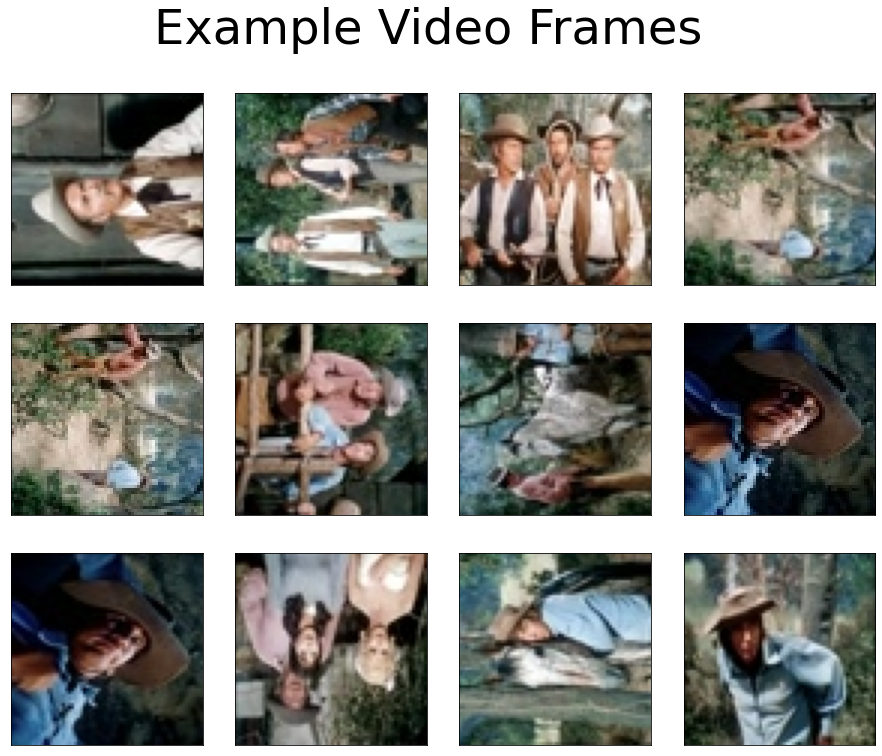

In [10]:
example_vid_paths = random.sample(os.listdir('../shows/episode3/'),12)
example_vid_paths = ['../shows/episode3/' + filename for filename in example_vid_paths]
example_frames = [utils.load_and_resize(path,transform=True) for path in example_vid_paths]

fig, ax = plt.subplots(3,4,figsize=(16,12))
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.imshow(example_frames[j+3*i])
        col.set_xticks([])
        col.set_yticks([])
fig.set_facecolor('#FFFFFF')
fig.subplots_adjust(wspace=0.02, hspace=0.2)
fig.suptitle('Example Video Frames',fontsize=48);

<h1>Training with Adversarial Loss</h1>
<h3>Model Selection</h3>

<p>
The GAN was selected as the model to colorize videos over the model trained purely using MSE. It was selected because it performed better than the MSE model in colorizing still images, producing more vibrant images with sharper details. The loss function for the GAN was also adjusted to have a lower weighting for the mean squared error component. This was done to reduce overfitting caused by the MSE component as there are many near duplicate frames in the dataset. 
</p>

<img src=resources/Gan_Arch.png width=300></img>

<p>
There were no changes to the generator or discriminator architecture other than the modified loss function for the generator. This new loss function is shown below.
</p>

In [ ]:
def generator_loss(disc_output_generated,generator_output,color_channels):

    # Part of the loss is based on the discriminator output on fake images
    cross_entropy = losses.BinaryCrossentropy(from_logits=True,label_smoothing=0.1)

    # Part of the loss (scaled) is based on the difference between the
    # generated images and the original colored images
    mse = losses.MeanSquaredError()
    mse_scaler = 25

    # Generator wants the discriminator to classify the generated images as 1 (real)
    # Adersarial loss is the defference between all 1s and the actual discriminator output
    adversarial_loss = cross_entropy(tf.ones_like(disc_output_generated),disc_output_generated)
    mse_loss = mse(generator_output,color_channels) 

    # Return all three losses for tensorboard
    return adversarial_loss + (mse_scaler * mse_loss), adversarial_loss, mse_loss

<h3>Training Results</h3>

<p>
The four charts below show the discriminator loss, generator loss(adversarial), generator loss (mean squared error), and total generator loss.
</p>

<ul>
<li>The discriminator loss starts high and decreases over time as the discriminator learns to distinguish between the generator's predicted colors and the original color images.</li>
<li>The generator adversarial loss is the inverse of the discriminator loss. It increases over time because the discriminator improves more quickly than the generator.</li>
<li>The generator MSE loss decreases over time as the generator predicted images more closely resemble the original color images. The overall MSE is likely lower than the image colorization model because it is easier to fit to the many near duplicate frames.</li>
<li>The generator total loss is the weighted sum of the adversarial and MSE loss components. The MSE component is weighted lower than in the image colorization model. The MSE component is larger initially, but the adversarial component eventually begins to dominate.</li>
</ul>

<img src=resources/Dusty_Loss_TBoard.jpg></img>

<p>
More information on the GAN used to colorize videos as well as the code used to train this model can be found in <a href=./Dusty_Colorizer.ipynb>this notebook</a>.
</p>

<h1>Video Colorization Results</h1>
<h3>Colorized Videos</h3>

<p>
Note, the example scenes were selected to avoid showing unfitting content.
</p>

<table>
    <tr>
        <th>Grayscale Video</th>
        <th>Colorized Video</th>
        <th>Original Video</th>
    <tr>
        <td><img src=resources/video/test_3_grayscale.gif width=256></img></td>
        <td><img src=resources/video/test_3_colorized.gif width=256></img></td>
        <td><img src=resources/video/test_3_original.gif width=256></img></td>
    </tr>
    <tr>
        <th>Grayscale Video</th>
        <th>Colorized Video</th>
        <th>Original Video</th>
    <tr>
    <tr>
        <td><img src=resources/video/test_14_grayscale.gif width=256></img></td>
        <td><img src=resources/video/test_14_colorized.gif width=256></img></td>
        <td><img src=resources/video/test_14_original.gif width=256></img></td>
    </tr>
    <tr>
        <th>Grayscale Video</th>
        <th>Colorized Video</th>
        <th>Original Video</th>
    <tr>
    <tr>
        <td><img src=resources/video/test_70_grayscale.gif width=256></img></td>
        <td><img src=resources/video/test_70_colorized.gif width=256></img></td>
        <td><img src=resources/video/test_70_original.gif width=256></img></td>
    </tr>
    <tr>
        <th>Grayscale Video</th>
        <th>Colorized Video</th>
        <th>Original Video</th>
    <tr>
    <tr>
        <td><img src=resources/video/test_120_grayscale.gif width=256></img></td>
        <td><img src=resources/video/test_120_colorized.gif width=256></img></td>
        <td><img src=resources/video/test_120_original.gif width=256></img></td>
    </tr>
</table>

<h3>Interpretation</h3>

<p>
<b>The interpretation of these results and the relative success of each model is highly subjective. Each person viewing the results may prefer a different colorization.</b>
</p>

<p >
The video colorizing model can be assessed by asking many of the same questions:
</p>

<ul>
<li>How well do the generator colorized videos match the original training and test videos?</li>
<li>Are the differences between the original and generator colorized videos expected or reasonable?</li>
<li>Are there any major defects or inconsistencies in the generator colorized videos?</li>
<li>Are the generator colorized videos vibrant and colorful when appropriate?</li>
<li>Do the predicted colors accentuate details in teh videos?</li>
</ul>

<p>
As well as some new questions:
</p>

<ul>
<li>Are the colors consistent frame-to-frame in the videos?</li>
<li>Do the colors track the boundaries of objects well as they move around in frame?</li>
</ul>


<p>
While many of the frames look good individually, there is definitely some noticable flashing and inconsistent coloring between frames. The colorization of the frames is also of a lower quality overall than the image colorization model. The object boundaries are not tracked nearly as well, and the model seems to be having trouble determining the color of clothing specifically. This is likely the result of the lower quality of the training dataset with its nearly duplicate frames. Likely, using more episodes with less frames from each episode would have produced a substantially better result. This issue is a major weakness of this model.
</p>

<p>
It is also unlikely that the random rotations helped as much as when training the model on landscapes. This is because a vast majority of the scenes in the television show are right side up as opposed to the landscapes where the orientations were much more varied. With the landscapes, the color blue could be on any side of the image for instance (the sky, the ocean, ect...). In Dusty's trail however, the color blue would almost always be the sky and the color brown would almost always be the ground.
</p>

<h1>Business Recommendations</h1>

<p>
First, BentoColor should make partnerships with image and movie rightshholders to acquire more video data. BentoColor should subsidize colorization services in exchange for the right to train future models on shows and movies owned by these partners. This will help BentoColor acquire new customers and form relationships with them. In addition, it will provide the necessary data to be used when training the next generation of models.
</p>

<p>
When creating the next generation of models, BentoColor should consider incorporating a classifier into the generator. An example of this architecture is shown in [<a href=https://arxiv.org/pdf/1712.03400.pdf>Deep Koalarization: Image Colorization using CNNs and Inception-ResNet-v2</a>]. Currently, the model can not determine whether it is coloring a shirt or a hat, and is only selecting colors for the image based on patterns of pixels. Adding a classifier to the model would provide it with context and likely improve colorization. This could not be incorporated into current models because most pre-trained classifiers require a larger image resolution than BentoColors' current hardware can process in a reasonable amount of time.
</p>

<p>
Finally, while the colorization model needs more work before it can automatically colorize videos, it can be deployed alongside current technology. It can colorize individual frames reasonably well which can provide a useful starting point for technicians. It is likely that fully automatic video colorization will be possible in the near future, but even the limited version available today can be a useful tool in the hands of talented technicians.
</p>

<h3>Resources Used</h3>

<a href=https://arxiv.org/abs/1712.03400>Deep Koalarization: Image Colorization using CNNs and Inception-ResNet-v2</a>

<a href=https://arxiv.org/abs/1611.07004>Image-to-Image Translation with Conditional Adversarial Networks</a>

<a href=https://arxiv.org/abs/1505.04597>U-Net: Convolutional Networks for Biomedical Image Segmentation</a>

<a href=https://www.tensorflow.org/tutorials/generative/pix2pix>pix2pix: Image-to-image translation with a conditional GAN</a>

<a href=https://www.flaticon.com/free-icon/bento_4073597>Flaticon</a>

